### yolov3 bounding box

In [12]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

image shape: (550, 986, 3)
output_layer name: ['yolo_82', 'yolo_94', 'yolo_106']
output shape: (507, 85)
output shape: (2028, 85)
output shape: (8112, 85)
2
[89, 121, 380, 421]
person: 0.9998
1
[428, 19, 552, 529]
person: 0.9974


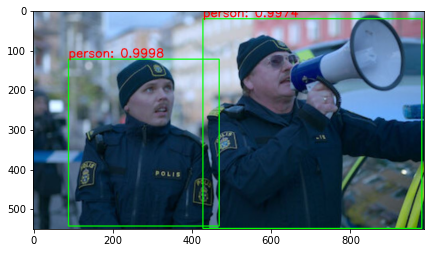

In [13]:
img = cv2.imread('image2.jpg')
# img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print('image shape:', img.shape)

#config 파일 인자가 먼저 옴. 
cv_net_yolo = cv2.dnn.readNetFromDarknet('./yolov3.cfg', './yolov3.weights')
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

#전체 Darknet layer에서 13x13 grid, 26x26, 52x52 grid에서 detect된 Output layer만 filtering
layer_names = cv_net_yolo.getLayerNames()
outlayer_names = [layer_names[i - 1] for i in cv_net_yolo.getUnconnectedOutLayers()]
print('output_layer name:', outlayer_names)

# 로딩한 모델은 Yolov3 416 x 416 모델임. 원본 이미지 배열을 사이즈 (416, 416)으로, BGR을 RGB로 변환하여 배열 입력
cv_net_yolo.setInput(cv2.dnn.blobFromImage(img, scalefactor=1/255.0, size=(416, 416), swapRB=True, crop=False))

# Object Detection 수행하여 결과를 cvOut으로 반환 
cv_outs = cv_net_yolo.forward(outlayer_names)
# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# 원본 이미지를 네트웍에 입력시에는 (416, 416)로 resize 함. 
# 이후 결과가 출력되면 resize된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
rows = img.shape[0]
cols = img.shape[1]

conf_threshold = 0.5
nms_threshold = 0.4

class_ids = []
confidences = []
boxes = []

# 3개의 개별 output layer별로 Detect된 Object들에 대해서 Detection 정보 추출 및 시각화 
for ix, output in enumerate(cv_outs):
    print('output shape:', output.shape)
    # Detected된 Object별 iteration
    for jx, detection in enumerate(output):
        # class score는 detetection배열에서 5번째 이후 위치에 있는 값. 
        scores = detection[5:]
        # scores배열에서 가장 높은 값을 가지는 값이 class confidence, 그리고 그때의 위치 인덱스가 class id
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        # confidence가 지정된 conf_threshold보다 작은 값은 제외 
        if confidence > conf_threshold:
            #print('ix:', ix, 'jx:', jx, 'class_id', class_id, 'confidence:', confidence)
            # detection은 scale된 좌상단, 우하단 좌표를 반환하는 것이 아니라, detection object의 중심좌표와 너비/높이를 반환
            # 원본 이미지에 맞게 scale 적용 및 좌상단, 우하단 좌표 계산
            center_x = int(detection[0] * cols)
            center_y = int(detection[1] * rows)
            width = int(detection[2] * cols)
            height = int(detection[3] * rows)
            left = int(center_x - width / 2)
            top = int(center_y - height / 2)
            # 3개의 개별 output layer별로 Detect된 Object들에 대한 class id, confidence, 좌표정보를 모두 수집
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([left, top, width, height])

conf_threshold = 0.5
nms_threshold = 0.4
idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성. 
draw_img = img.copy()

# NMS로 최종 filtering된 idxs를 이용하여 boxes, classes, confidences에서 해당하는 Object정보를 추출하고 시각화.
if len(idxs) > 0:
    for i in idxs.flatten():
        print(i)
        box = boxes[i]
        print(box)
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        # labels_to_names 딕셔너리로 class_id값을 클래스명으로 변경. opencv에서는 class_id + 1로 매핑해야함.
        caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
        #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
        cv2.rectangle(draw_img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)
        cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 1, red_color, 2)
        print(caption)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7, 6))
plt.imshow(img_rgb)
plt.show()

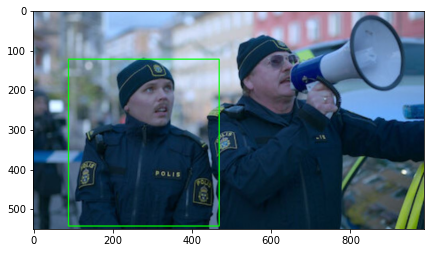

In [4]:
person_box = [89, 121, 380, 421]

left = person_box[0]
top = person_box[1]
width = person_box[2]
height = person_box[3]

cv2.rectangle(img, (int(left), int(top)), (int(left+width), int(top+height)), color=green_color, thickness=2)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7, 6))
plt.imshow(img_rgb)
plt.show()

In [5]:
img = img_rgb[top:top+height, left:left+width]

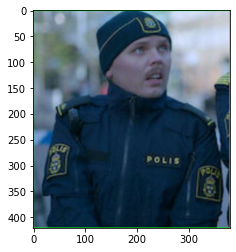

In [6]:
plt.imshow(img)
plt.show()

In [7]:
net = cv2.dnn.readNetFromTensorflow('graph_opt.pb')

inWidth = 368
inHeight = 368
thr = 0.2

In [8]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
                "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
                "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
                "LEye": 15, "REar": 16, "LEar": 17, "Background": 18}

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
                ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
                ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
                ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
                ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [9]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv2.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), 
    swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv2.minMaxLoc(heatMap)
        #heatmap은 최대값 위치를 찾아서 point에, 최대값 자체는 conf에 저장한다. 최소값은 안쓰니 밑줄 !, point는 46 by 46 에서의 위치인데, 입력영상에서의 위치를 찾는 것이니,!! 여기서 전체 w h에서의 위치를 비례식으로 찾는다.
        x = int(frameWidth * point[0] / out.shape[3])
        y = int(frameHeight * point[1] / out.shape[2])

        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv2.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv2.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
            cv2.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv2.getTickFrequency() / 1000
    cv2.putText(frame, '%.2fms' % (t / freq), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return frame


In [10]:
estimated_image = pose_estimation(img)

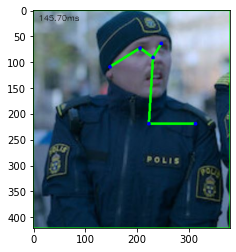

In [11]:
plt.imshow(estimated_image)
plt.show()